In [1]:
%pip install chromadb sentence-transformers rank-bm25 pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 103.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 127.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 97.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.

In [2]:
import json
import pickle
import numpy as np
from typing import List, Tuple, Dict, Set
from tqdm import tqdm
from collections import defaultdict
import chromadb
from chromadb.config import Settings
import shutil
import os
from sentence_transformers import SentenceTransformer
import torch

# Paths
BM25_INDEX_PATH = "/kaggle/input/d/phmthn/bm25-index/bm25_index.pkl"
CHROMA_DB_PATH = "/kaggle/input/chroma-db-retriever/chroma_db_retriever"
TRAIN_FILE = "/kaggle/input/vlqa-dataset/train.json"
LEGAL_CORPUS_FILE = "/kaggle/input/vlqa-dataset/legal_corpus.json"

# GridSearch parameters
W2_VALUES = np.linspace(0.0, 0.9, 10) 
TOP_K_RETRIEVE = 200

2025-12-04 14:02:49.308550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764856969.488461      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764856969.540135      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# Load BM25 Index
print("Loading BM25 index...")
with open(BM25_INDEX_PATH, 'rb') as f:
    bm25_data = pickle.load(f)

# BM25 Retriever (FIXED: Aggregation by AID + Better Tokenizer)
class BM25Retriever:
    def __init__(self, bm25_data, chroma_collection=None):
        """
        Initialize BM25 Retriever.
        
        Args:
            bm25_data: Loaded pickle data from bm25_index.pkl
            chroma_collection: ChromaDB collection instance (optional, for mapping chunk_id -> aid)
        """
        # Load data from pickle (structure from bm25_retriever.save())
        self.corpus_size = bm25_data['corpus_size']
        self.avgdl = bm25_data['avgdl']
        self.doc_lengths = bm25_data['doc_lengths']
        self.doc_ids = bm25_data['doc_ids']
        self.index_to_id = bm25_data.get('index_to_id', {})
        self.inverted_index = bm25_data['inverted_index']
        self.idf = bm25_data['idf']
        self.k1 = 1.5
        self.b = 0.75
        
        # ChromaDB collection for mapping chunk_id -> aid (if needed)
        self.chroma_collection = chroma_collection
        
        # Cache for doc_id -> aid mapping (to avoid repeated queries)
        self._doc_id_to_aid_cache = {}
        
        # FIX TOKENIZER: Try pyvi for Vietnamese, fallback to simple split
        try:
            from pyvi import ViTokenizer
            self.tokenizer = lambda x: ViTokenizer.tokenize(x).split()
            print("✅ BM25: Using Pyvi tokenizer for Vietnamese")
        except ImportError:
            try:
                import underthesea
                self.tokenizer = lambda x: underthesea.word_tokenize(x.lower())
                print("✅ BM25: Using Underthesea tokenizer for Vietnamese")
            except ImportError:
                # Fallback: simple split (worse for Vietnamese)
                print("⚠️ BM25: Using simple split (install 'pyvi' or 'underthesea' for better Vietnamese tokenization)")
                self.tokenizer = lambda x: x.lower().split()
    
    def _get_aid_from_doc_id(self, doc_id: str) -> str:
        """
        Get article ID (aid) from document ID (chunk_id).
        If doc_id is already aid, return it. Otherwise, query ChromaDB.
        """
        if doc_id in self._doc_id_to_aid_cache:
            return self._doc_id_to_aid_cache[doc_id]
        
        # Try 1: Assume doc_id is already aid (if index was built with aid as id)
        aid = doc_id
        
        # Try 2: Query ChromaDB to get aid from metadata
        if self.chroma_collection:
            try:
                # Query by doc_id (chunk_id)
                results = self.chroma_collection.get(
                    ids=[doc_id],
                    include=["metadatas"]
                )
                if results and results.get('metadatas') and len(results['metadatas']) > 0:
                    metadata = results['metadatas'][0]
                    if metadata and 'aid' in metadata:
                        aid = str(metadata['aid'])
            except Exception as e:
                # If query fails, assume doc_id is aid
                pass
        
        # Cache the result
        self._doc_id_to_aid_cache[doc_id] = aid
        return aid
    
    def retrieve(self, query: str, top_k: int = 100) -> List[Tuple[str, float]]:
        """
        Retrieve top-k documents using BM25 with AGGREGATION BY AID.
        Similar to DenseRetriever, groups chunks by article and keeps max score.
        """
        if self.corpus_size == 0:
            return []
        
        # Tokenize query
        query_tokens = self.tokenizer(query)
        scores = defaultdict(float)
        
        # Calculate BM25 scores for all chunks
        for token in query_tokens:
            if token not in self.inverted_index:
                continue
            
            idf_score = self.idf[token]
            
            for doc_idx, term_freq in self.inverted_index[token].items():
                doc_len = self.doc_lengths[doc_idx]
                
                numerator = term_freq * (self.k1 + 1)
                denominator = term_freq + self.k1 * (1 - self.b + self.b * (doc_len / self.avgdl))
                score = idf_score * (numerator / denominator)
                
                scores[doc_idx] += score
        
        # FIX: AGGREGATION BY ARTICLE ID (AID)
        # Group scores by aid (similar to DenseRetriever)
        article_scores = defaultdict(float)
        
        for doc_idx, score in scores.items():
            doc_id = str(self.index_to_id.get(doc_idx, doc_idx))
            # Get aid from doc_id (chunk_id)
            aid = self._get_aid_from_doc_id(doc_id)
            
            # Keep MAX score for each article (if multiple chunks)
            if score > article_scores[aid]:
                article_scores[aid] = score
        
        # Sort by score and return top-k
        sorted_scores = sorted(article_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        
        return [(str(aid), float(score)) for aid, score in sorted_scores]

# Note: chroma_collection will be passed after Cell 3 loads ChromaDB
# For now, initialize without it (will be updated later)
bm25_retriever = BM25Retriever(bm25_data)

Loading BM25 index...
✅ BM25: Using Pyvi tokenizer for Vietnamese


In [4]:
# Load ChromaDB (BGE-M3)
# Copy database to writable directory first (Kaggle input is read-only)
import shutil
import os
from sentence_transformers import SentenceTransformer
import torch

WORKING_CHROMA_PATH = "/kaggle/working/chroma_db_retriever"

print("Copying ChromaDB to working directory...")
if os.path.exists(WORKING_CHROMA_PATH):
    shutil.rmtree(WORKING_CHROMA_PATH)
shutil.copytree(CHROMA_DB_PATH, WORKING_CHROMA_PATH)
print(f"Copied to: {WORKING_CHROMA_PATH}")

print("Loading BGE-M3 embedding model...")
# BGE-M3 model for 1024 dimension embeddings
BGE_M3_MODEL = "BAAI/bge-m3"
device = "cuda" if torch.cuda.is_available() else "cpu"
bge_m3_model = SentenceTransformer(BGE_M3_MODEL, device=device)
print(f"BGE-M3 model loaded on {device}")
print(f"Embedding dimension: {bge_m3_model.get_sentence_embedding_dimension()}")

print("Loading ChromaDB retriever...")
chroma_client = chromadb.PersistentClient(
    path=WORKING_CHROMA_PATH,
    settings=Settings(anonymized_telemetry=False)
)

# Get collection (thường là 'retriever_legal_articles' hoặc tên tương tự)
# List collections để tìm đúng collection name
collections = chroma_client.list_collections()
print(f"Available collections: {[c.name for c in collections]}")

# Sử dụng collection đầu tiên hoặc tên cụ thể
if collections:
    collection = chroma_client.get_collection(name=collections[0].name)
    print(f"Using collection: {collection.name}")
    print(f"Collection count: {collection.count()}")
    
    # Check collection metadata for expected dimension
    metadata = collection.metadata or {}
    print(f"Collection metadata: {metadata}")
else:
    raise ValueError("No collections found in ChromaDB")

def retrieve_from_chroma(query: str, top_k: int = 100) -> List[Tuple[str, float]]:
    """Retrieve from ChromaDB using BGE-M3 embeddings"""
    try:
        # Encode query using BGE-M3 model
        query_embedding = bge_m3_model.encode(
            query,
            convert_to_numpy=True,
            normalize_embeddings=True,  # Important for cosine similarity
            show_progress_bar=False
        )
        
        # Query ChromaDB using embeddings (not text)
        results = collection.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=top_k,
            include=['metadatas', 'distances']
        )
    except Exception as e:
        print(f"Error querying ChromaDB: {e}")
        return []
    
    if not results['ids'] or not results['ids'][0]:
        return []
    
    ids = results['ids'][0]
    metadatas = results.get('metadatas', [[]])[0] if 'metadatas' in results else []
    
    # Get distances if available
    if 'distances' in results and results['distances']:
        distances = results['distances'][0]
    else:
        # Fallback: use default scores
        distances = [0.0] * len(ids)
    
    # Convert distance to similarity score (1 - distance for cosine)
    # Group by article ID (aid) and keep best score for each article
    article_scores = {}
    for i, doc_id in enumerate(ids):
        # Extract article ID from metadata if available
        if i < len(metadatas) and metadatas[i]:
            aid = metadatas[i].get('aid', str(doc_id))
        else:
            # Fallback: use doc_id as aid (assuming it's already an article ID)
            aid = str(doc_id)
        
        if i < len(distances) and isinstance(distances[i], (int, float)):
            # Distance-based: convert to similarity
            score = max(0.0, min(1.0, 1.0 - distances[i]))
        else:
            # Fallback: use default score
            score = 1.0
        
        # Keep best score for each article
        if aid not in article_scores or score > article_scores[aid]:
            article_scores[aid] = score
    
    # Convert to list of tuples
    retrieved_items = [(aid, score) for aid, score in article_scores.items()]
    # Sort by score descending
    retrieved_items.sort(key=lambda x: x[1], reverse=True)
    
    return retrieved_items[:top_k]

print("ChromaDB retriever ready with BGE-M3 embeddings")

Copying ChromaDB to working directory...
Copied to: /kaggle/working/chroma_db_retriever
Loading BGE-M3 embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

BGE-M3 model loaded on cuda
Embedding dimension: 1024
Loading ChromaDB retriever...
Available collections: ['retriever_legal_articles']
Using collection: retriever_legal_articles
Collection count: 74352
Collection metadata: {'hnsw:space': 'cosine'}
ChromaDB retriever ready with BGE-M3 embeddings


In [5]:
# Update BM25Retriever with ChromaDB collection for aid mapping
print("Updating BM25Retriever with ChromaDB collection...")
bm25_retriever.chroma_collection = collection

Updating BM25Retriever with ChromaDB collection...


In [6]:
# Load train data và corpus
with open(TRAIN_FILE, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(LEGAL_CORPUS_FILE, 'r', encoding='utf-8') as f:
    legal_corpus = json.load(f)

# Build article_id to content mapping
article_id_to_content = {}
for doc in legal_corpus:
    for article in doc.get('content', []):
        aid = article.get('aid')
        content = article.get('content_Article', '')
        if aid and content:
            article_id_to_content[aid] = content

print(f"Train samples: {len(train_data)}")
print(f"Articles in corpus: {len(article_id_to_content)}")

Train samples: 2190
Articles in corpus: 59634


In [ ]:
# Evaluation functions
TOP_K_EVAL = 100  # Top-k for evaluation metrics

def calculate_ndcg_at_k(predicted_ids: List[str], relevant_ids: List[str], k: int = 10) -> float:
    """
    Calculate nDCG@k (Normalized Discounted Cumulative Gain at k)
    
    Args:
        predicted_ids: List of predicted article IDs (ranked)
        relevant_ids: List of relevant article IDs
        k: Top-k to consider
    
    Returns:
        nDCG@k score
    """
    relevant_set = set(relevant_ids)
    
    # Calculate DCG@k
    dcg = 0.0
    for i, doc_id in enumerate(predicted_ids[:k], start=1):
        if doc_id in relevant_set:
            # Gain = 1 if relevant, 0 otherwise
            gain = 1.0
            # Discounted by log2(i+1)
            dcg += gain / np.log2(i + 1)
    
    # Calculate IDCG@k (Ideal DCG)
    num_relevant = min(len(relevant_set), k)
    if num_relevant == 0:
        return 0.0
    
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, num_relevant + 1))
    
    # nDCG = DCG / IDCG
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

def calculate_mrr_at_k(predicted_ids: List[str], relevant_ids: List[str], k: int = 10) -> float:
    """
    Calculate MRR@k (Mean Reciprocal Rank at k)
    
    Args:
        predicted_ids: List of predicted article IDs (ranked)
        relevant_ids: List of relevant article IDs
        k: Top-k to consider
    
    Returns:
        MRR@k score (reciprocal rank of first relevant item)
    """
    relevant_set = set(relevant_ids)
    
    # Find first relevant item in top-k
    for i, doc_id in enumerate(predicted_ids[:k], start=1):
        if doc_id in relevant_set:
            return 1.0 / i
    
    # No relevant item found
    return 0.0

def calculate_recall_at_k(predicted_ids: List[str], relevant_ids: List[str], k: int = 10) -> float:
    """
    Calculate Recall@k
    
    Args:
        predicted_ids: List of predicted article IDs (ranked)
        relevant_ids: List of relevant article IDs
        k: Top-k to consider
    
    Returns:
        Recall@k score
    """
    relevant_set = set(relevant_ids)
    if len(relevant_set) == 0:
        return 0.0
    
    # Count relevant items in top-k
    predicted_set = set(predicted_ids[:k])
    relevant_retrieved = len(predicted_set & relevant_set)
    
    # Recall = relevant_retrieved / total_relevant
    recall = relevant_retrieved / len(relevant_set)
    return recall

def calculate_metrics(predicted_ids: List[str], relevant_ids: List[str], k: int = 10) -> Dict[str, float]:
    """
    Calculate nDCG@k, MRR@k, Recall@k
    
    Args:
        predicted_ids: List of predicted article IDs (ranked, top-k)
        relevant_ids: List of relevant article IDs
        k: Top-k for evaluation
    
    Returns:
        Dictionary with metrics
    """
    ndcg = calculate_ndcg_at_k(predicted_ids, relevant_ids, k)
    mrr = calculate_mrr_at_k(predicted_ids, relevant_ids, k)
    recall = calculate_recall_at_k(predicted_ids, relevant_ids, k)
    
    return {
        "ndcg@k": ndcg,
        "mrr@k": mrr,
        "recall@k": recall,
        "k": k
    }

def normalize_scores(scores: Dict[str, float]) -> Dict[str, float]:
    """Normalize scores to [0, 1] range"""
    if not scores:
        return {}
    values = list(scores.values())
    min_score = min(values)
    max_score = max(values)
    if max_score == min_score:
        return {k: 1.0 for k in scores}
    return {k: (v - min_score) / (max_score - min_score) for k, v in scores.items()}

def weighted_ensemble(
    bm25_results: List[Tuple[str, float]],
    chroma_results: List[Tuple[str, float]],
    w1: float,
    w2: float,
    top_k: int = 1
) -> List[Tuple[str, float]]:
    """
    Combine BM25 and ChromaDB results using weighted ensemble
    
    Args:
        bm25_results: List of (doc_id, score) from BM25
        chroma_results: List of (doc_id, score) from ChromaDB
        w1: Weight for BM25
        w2: Weight for ChromaDB (BGE-M3)
        top_k: Number of top results to return
    
    Returns:
        List of (doc_id, combined_score) sorted by score
    """
    # Convert to dicts
    bm25_scores = dict(bm25_results)
    chroma_scores = dict(chroma_results)
    
    # Normalize scores
    norm_bm25 = normalize_scores(bm25_scores)
    norm_chroma = normalize_scores(chroma_scores)
    
    # Get all document IDs
    all_ids = set(norm_bm25.keys()) | set(norm_chroma.keys())
    
    # Calculate weighted scores
    final_scores = {}
    for doc_id in all_ids:
        s1 = norm_bm25.get(doc_id, 0.0)
        s2 = norm_chroma.get(doc_id, 0.0)
        final_scores[doc_id] = (w1 * s1) + (w2 * s2)
    
    # Sort by score (descending)
    sorted_docs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_docs[:top_k]

In [8]:
# Debug: Test retrieval và check ID format + Normalization
print("Testing retrieval and ID format...")
test_query = train_data[0]['question']
test_relevant = [str(law_id) for law_id in train_data[0]['relevant_laws']]

print(f"Test query: {test_query[:50]}...")
print(f"Relevant laws (as strings): {test_relevant}")

# Test BM25
bm25_test = bm25_retriever.retrieve(test_query, top_k=5)
print(f"\nBM25 results (top 5) - BEFORE NORMALIZATION:")
for aid, score in bm25_test[:5]:
    print(f"  {aid} (type: {type(aid).__name__}) - score: {score:.4f}")
    if str(aid) in test_relevant:
        print(f"    ✓ MATCH with relevant laws!")

# Test ChromaDB
chroma_test = retrieve_from_chroma(test_query, top_k=5)
print(f"\nChromaDB results (top 5) - BEFORE NORMALIZATION:")
for aid, score in chroma_test[:5]:
    print(f"  {aid} (type: {type(aid).__name__}) - score: {score:.4f}")
    if str(aid) in test_relevant:
        print(f"    ✓ MATCH with relevant laws!")

# Show normalization process
print(f"\n{'='*80}")
print("NORMALIZATION PROCESS:")
print(f"{'='*80}")
bm25_scores = dict(bm25_test)
chroma_scores = dict(chroma_test)

# Normalize BM25 scores
if bm25_scores:
    bm25_values = list(bm25_scores.values())
    bm25_min = min(bm25_values)
    bm25_max = max(bm25_values)
    norm_bm25 = normalize_scores(bm25_scores)
    print(f"\nBM25 Scores Normalization:")
    print(f"  Min: {bm25_min:.4f}, Max: {bm25_max:.4f}")
    print(f"  Formula: (score - {bm25_min:.4f}) / ({bm25_max:.4f} - {bm25_min:.4f})")
    print(f"  After normalization (top 5):")
    for i, (aid, score) in enumerate(bm25_test[:5]):
        norm_score = norm_bm25.get(aid, 0.0)
        print(f"    {aid}: {score:.4f} -> {norm_score:.4f}")

# Normalize ChromaDB scores
if chroma_scores:
    chroma_values = list(chroma_scores.values())
    chroma_min = min(chroma_values)
    chroma_max = max(chroma_values)
    norm_chroma = normalize_scores(chroma_scores)
    print(f"\nChromaDB Scores Normalization:")
    print(f"  Min: {chroma_min:.4f}, Max: {chroma_max:.4f}")
    print(f"  Formula: (score - {chroma_min:.4f}) / ({chroma_max:.4f} - {chroma_min:.4f})")
    print(f"  After normalization (top 5):")
    for i, (aid, score) in enumerate(chroma_test[:5]):
        norm_score = norm_chroma.get(aid, 0.0)
        print(f"    {aid}: {score:.4f} -> {norm_score:.4f}")

# Test ensemble
if bm25_test and chroma_test:
    ensemble_test = weighted_ensemble(bm25_test, chroma_test, w1=0.5, w2=0.5, top_k=TOP_K_EVAL)
    print(f"\n{'='*80}")
    print("ENSEMBLE RESULTS (after normalization + weighted combination):")
    print(f"{'='*80}")
    for aid, score in ensemble_test[:10]:
        match = "✓ MATCH" if str(aid) in test_relevant else ""
        print(f"  {aid} - score: {score:.4f} {match}")
    
    # Test metrics
    top_k_ids = [str(result[0]) for result in ensemble_test]
    test_metrics = calculate_metrics(top_k_ids, test_relevant, k=TOP_K_EVAL)
    print(f"\nTest metrics:")
    print(f"  nDCG@100: {test_metrics['ndcg@k']:.4f}")
    print(f"  MRR@100: {test_metrics['mrr@k']:.4f}")
    print(f"  Recall@100: {test_metrics['recall@k']:.4f}")

Testing retrieval and ID format...
Test query: Thưa luật sư tôi có đăng ký kết hôn trên pháp luật...
Relevant laws (as strings): ['53877', '53875', '53929']

BM25 results (top 5) - BEFORE NORMALIZATION:
  3441 (type: str) - score: 52.6294
  6740 (type: str) - score: 50.4959
  5849 (type: str) - score: 48.0459
  53886 (type: str) - score: 47.9192
  53875 (type: str) - score: 47.5840
    ✓ MATCH with relevant laws!

ChromaDB results (top 5) - BEFORE NORMALIZATION:
  57800 (type: str) - score: 0.4907
  53875 (type: str) - score: 0.4636
    ✓ MATCH with relevant laws!
  52775 (type: str) - score: 0.4430
  53877 (type: str) - score: 0.4421
    ✓ MATCH with relevant laws!
  53880 (type: str) - score: 0.4415

NORMALIZATION PROCESS:

BM25 Scores Normalization:
  Min: 47.5840, Max: 52.6294
  Formula: (score - 47.5840) / (52.6294 - 47.5840)
  After normalization (top 5):
    3441: 52.6294 -> 1.0000
    6740: 50.4959 -> 0.5771
    5849: 48.0459 -> 0.0915
    53886: 47.9192 -> 0.0664
    53875: 47

In [9]:
# GridSearch: Evaluate với các giá trị W2 khác nhau
print("="*80)
print("STARTING GRIDSEARCH")
print("="*80)
print(f"W2 values to test: {W2_VALUES}")
print(f"W1 = 1 - W2")
print(f"Evaluating on {len(train_data)} train samples")
print("="*80)

results_grid = []

# Single progress bar for all iterations
total_iterations = len(W2_VALUES) * len(train_data)
current_iter = 0

pbar = tqdm(total=total_iterations, desc="GridSearch", ncols=100, mininterval=0.5, leave=False)

for w2_idx, w2 in enumerate(W2_VALUES):
    w1 = 1.0 - w2
    
    all_metrics = []
    
    for item_idx, item in enumerate(train_data):
        qid = item['qid']
        question = item['question']
        # Convert relevant_laws to strings for comparison
        relevant_laws = [str(law_id) for law_id in item['relevant_laws']]
        
        # Update progress bar description
        pbar.set_description(
            f"W2={w2:.1f} ({w2_idx+1}/{len(W2_VALUES)}) | "
            f"Sample {item_idx+1}/{len(train_data)}"
        )
        
        # Retrieve from BM25
        try:
            bm25_results = bm25_retriever.retrieve(question, top_k=TOP_K_RETRIEVE)
        except:
            bm25_results = []
        
        # Retrieve from ChromaDB (BGE-M3)
        try:
            chroma_results = retrieve_from_chroma(question, top_k=TOP_K_RETRIEVE)
        except:
            chroma_results = []
        
        # Combine using weighted ensemble
        if not bm25_results and not chroma_results:
            # No results, skip
            pbar.update(1)
            current_iter += 1
            continue
        
        ensemble_results = weighted_ensemble(
            bm25_results,
            chroma_results,
            w1=w1,
            w2=w2,
            top_k=TOP_K_EVAL
        )
        
        if not ensemble_results:
            pbar.update(1)
            current_iter += 1
            continue
        
        # Get top-k article IDs (ensure they are strings)
        top_k_article_ids = [str(result[0]) for result in ensemble_results]
        
        # Calculate metrics (relevant_laws is already list of strings)
        metrics = calculate_metrics(top_k_article_ids, relevant_laws, k=TOP_K_EVAL)
        metrics['qid'] = qid
        all_metrics.append(metrics)
        
        # Update progress bar
        pbar.update(1)
        current_iter += 1
    
    # Calculate average metrics
    if all_metrics:
        avg_ndcg = np.mean([m['ndcg@k'] for m in all_metrics])
        avg_mrr = np.mean([m['mrr@k'] for m in all_metrics])
        avg_recall = np.mean([m['recall@k'] for m in all_metrics])
        
        results_grid.append({
            'w1': w1,
            'w2': w2,
            'ndcg@k': avg_ndcg,
            'mrr@k': avg_mrr,
            'recall@k': avg_recall,
            'n_samples': len(all_metrics)
        })
        
        # Update progress bar with results
        pbar.set_postfix({
            'nDCG@100': f'{avg_ndcg:.4f}',
            'MRR@100': f'{avg_mrr:.4f}',
            'Recall@100': f'{avg_recall:.4f}'
        })

# Close progress bar
pbar.close()

print("\n" + "="*80)
print("GRIDSEARCH COMPLETED")
print("="*80)

STARTING GRIDSEARCH
W2 values to test: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
W1 = 1 - W2
Evaluating on 2190 train samples



GRIDSEARCH COMPLETED


In [13]:
# Tìm weights tối ưu dựa trên Recall@100 score
if results_grid:
    # Sort by Recall@100 score (descending) - primary metric
    results_sorted_recall = sorted(results_grid, key=lambda x: x['recall@k'], reverse=True)
    best_result_recall = results_sorted_recall[0]
    
    # Also sort by nDCG@100
    results_sorted_ndcg = sorted(results_grid, key=lambda x: x['ndcg@k'], reverse=True)
    best_result_ndcg = results_sorted_ndcg[0]
    
    # Also sort by MRR@100
    results_sorted_mrr = sorted(results_grid, key=lambda x: x['mrr@k'], reverse=True)
    best_result_mrr = results_sorted_mrr[0]
    
    print("="*80)
    print("BEST WEIGHTS (based on Recall@100)")
    print("="*80)
    print(f"W1 (BM25 weight): {best_result_recall['w1']:.4f}")
    print(f"W2 (BGE-M3 weight): {best_result_recall['w2']:.4f}")
    print(f"\nMetrics:")
    print(f"  Recall@100: {best_result_recall['recall@k']:.4f}")
    print(f"  nDCG@100:   {best_result_recall['ndcg@k']:.4f}")
    print(f"  MRR@100:    {best_result_recall['mrr@k']:.4f}")
    print(f"  Samples:   {best_result_recall['n_samples']}")
    print("="*80)
    
    print("\n" + "="*80)
    print("BEST WEIGHTS (based on nDCG@100)")
    print("="*80)
    print(f"W1 (BM25 weight): {best_result_ndcg['w1']:.4f}")
    print(f"W2 (BGE-M3 weight): {best_result_ndcg['w2']:.4f}")
    print(f"  Recall@100: {best_result_ndcg['recall@k']:.4f}")
    print(f"  nDCG@100:   {best_result_ndcg['ndcg@k']:.4f}")
    print(f"  MRR@100:    {best_result_ndcg['mrr@k']:.4f}")
    print("="*80)
    
    print("\n" + "="*80)
    print("BEST WEIGHTS (based on MRR@100)")
    print("="*80)
    print(f"W1 (BM25 weight): {best_result_mrr['w1']:.4f}")
    print(f"W2 (BGE-M3 weight): {best_result_mrr['w2']:.4f}")
    print(f"  Recall@100: {best_result_mrr['recall@k']:.4f}")
    print(f"  nDCG@100:   {best_result_mrr['ndcg@k']:.4f}")
    print(f"  MRR@100:    {best_result_mrr['mrr@k']:.4f}")
    print("="*80)
    
    # Show top 5 results by Recall@100
    print("\nTop 5 configurations (by Recall@100):")
    print("-"*80)
    for i, result in enumerate(results_sorted_recall[:5], 1):
        print(f"{i}. W1={result['w1']:.2f}, W2={result['w2']:.2f}: "
              f"Recall@100={result['recall@k']:.4f}, nDCG@100={result['ndcg@k']:.4f}, "
              f"MRR@100={result['mrr@k']:.4f}")
else:
    print("No results to display")

BEST WEIGHTS (based on Recall@100)
W1 (BM25 weight): 0.3000
W2 (BGE-M3 weight): 0.7000

Metrics:
  Recall@100: 0.9335
  nDCG@100:   0.6357
  MRR@100:    0.5884
  Samples:   2190

BEST WEIGHTS (based on nDCG@100)
W1 (BM25 weight): 0.4000
W2 (BGE-M3 weight): 0.6000
  Recall@100: 0.9317
  nDCG@100:   0.6489
  MRR@100:    0.6056

BEST WEIGHTS (based on MRR@100)
W1 (BM25 weight): 0.4000
W2 (BGE-M3 weight): 0.6000
  Recall@100: 0.9317
  nDCG@100:   0.6489
  MRR@100:    0.6056

Top 5 configurations (by Recall@100):
--------------------------------------------------------------------------------
1. W1=0.30, W2=0.70: Recall@100=0.9335, nDCG@100=0.6357, MRR@100=0.5884
2. W1=0.40, W2=0.60: Recall@100=0.9317, nDCG@100=0.6489, MRR@100=0.6056
3. W1=0.50, W2=0.50: Recall@100=0.9312, nDCG@100=0.6460, MRR@100=0.6022
4. W1=0.20, W2=0.80: Recall@100=0.9307, nDCG@100=0.6147, MRR@100=0.5623
5. W1=0.60, W2=0.40: Recall@100=0.9250, nDCG@100=0.6289, MRR@100=0.5824


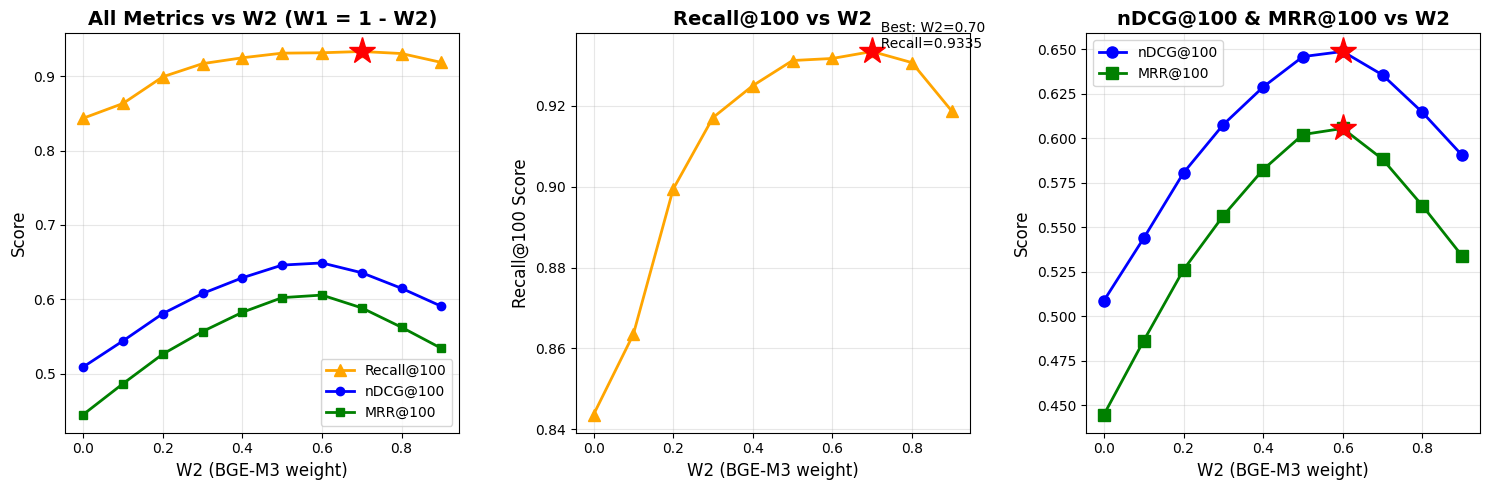


Best configuration (Recall@100): W1=0.3000, W2=0.7000
Best Recall@100 score: 0.9335
Best nDCG@100 score: 0.6489 (at W2=0.60)
Best MRR@100 score: 0.6056 (at W2=0.60)


In [14]:
# Visualize results
import matplotlib.pyplot as plt

if results_grid:
    w2_values = [r['w2'] for r in results_grid]
    ndcg_scores = [r['ndcg@k'] for r in results_grid]
    mrr_scores = [r['mrr@k'] for r in results_grid]
    recall_scores = [r['recall@k'] for r in results_grid]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(w2_values, recall_scores, '^-', label='Recall@100', linewidth=2, markersize=8, color='orange')
    plt.plot(w2_values, ndcg_scores, 'o-', label='nDCG@100', linewidth=2, markersize=6, color='blue')
    plt.plot(w2_values, mrr_scores, 's-', label='MRR@100', linewidth=2, markersize=6, color='green')
    plt.xlabel('W2 (BGE-M3 weight)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('All Metrics vs W2 (W1 = 1 - W2)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Mark best point for Recall (primary metric)
    best_idx_recall = np.argmax(recall_scores)
    plt.plot(w2_values[best_idx_recall], recall_scores[best_idx_recall], 'r*', markersize=20, label='Best Recall')
    
    plt.subplot(1, 3, 2)
    plt.plot(w2_values, recall_scores, '^-', linewidth=2, markersize=8, color='orange')
    plt.xlabel('W2 (BGE-M3 weight)', fontsize=12)
    plt.ylabel('Recall@100 Score', fontsize=12)
    plt.title('Recall@100 vs W2', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.plot(w2_values[best_idx_recall], recall_scores[best_idx_recall], 'r*', markersize=20)
    plt.text(w2_values[best_idx_recall], recall_scores[best_idx_recall], 
             f'  Best: W2={w2_values[best_idx_recall]:.2f}\n  Recall={recall_scores[best_idx_recall]:.4f}',
             fontsize=10, verticalalignment='bottom')
    
    plt.subplot(1, 3, 3)
    plt.plot(w2_values, ndcg_scores, 'o-', linewidth=2, markersize=8, color='blue', label='nDCG@100')
    plt.plot(w2_values, mrr_scores, 's-', linewidth=2, markersize=8, color='green', label='MRR@100')
    plt.xlabel('W2 (BGE-M3 weight)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('nDCG@100 & MRR@100 vs W2', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Mark best points
    best_idx_ndcg = np.argmax(ndcg_scores)
    best_idx_mrr = np.argmax(mrr_scores)
    plt.plot(w2_values[best_idx_ndcg], ndcg_scores[best_idx_ndcg], 'r*', markersize=20)
    plt.plot(w2_values[best_idx_mrr], mrr_scores[best_idx_mrr], 'r*', markersize=20)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest configuration (Recall@100): W1={1-w2_values[best_idx_recall]:.4f}, W2={w2_values[best_idx_recall]:.4f}")
    print(f"Best Recall@100 score: {recall_scores[best_idx_recall]:.4f}")
    print(f"Best nDCG@100 score: {ndcg_scores[best_idx_ndcg]:.4f} (at W2={w2_values[best_idx_ndcg]:.2f})")
    print(f"Best MRR@100 score: {mrr_scores[best_idx_mrr]:.4f} (at W2={w2_values[best_idx_mrr]:.2f})")

In [15]:
# Export results to JSON
if results_grid:
    output_file = "weighted_ensemble_gridsearch_results.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results_grid, f, indent=2, ensure_ascii=False)
    print(f"\nResults saved to: {output_file}")
    
    # Also save best weights (by Recall@100 - primary metric)
    best_weights = {
        "w1": best_result_recall['w1'],
        "w2": best_result_recall['w2'],
        "recall@k": best_result_recall['recall@k'],
        "ndcg@k": best_result_recall['ndcg@k'],
        "mrr@k": best_result_recall['mrr@k'],
        "k": TOP_K_EVAL
    }
    
    best_weights_file = "best_weights.json"
    with open(best_weights_file, 'w', encoding='utf-8') as f:
        json.dump(best_weights, f, indent=2, ensure_ascii=False)
    print(f"Best weights saved to: {best_weights_file}")


Results saved to: weighted_ensemble_gridsearch_results.json
Best weights saved to: best_weights.json
